In [1]:
# Import essential libraries for data analysis and machine learning
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Import preprocessing tools for data transformation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# Import cross-validation tools for model evaluation
from sklearn.model_selection import KFold, cross_val_predict
# Import regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# Import metric for model performance evaluation
from sklearn.metrics import r2_score
# Import Pipeline for chaining multiple processing steps
from sklearn.pipeline import Pipeline

In [2]:
# Load the Boston housing dataset from pickle file
# Fixed: Updated path to match actual file location
# The pickle file contains preprocessed Boston housing data
boston = pickle.load(open('boston_housing_clean.pickle', "rb" ))

In [3]:
# Display the keys in the loaded Boston dataset dictionary
# This shows what data structures are available
boston.keys()

dict_keys(['dataframe', 'description'])

In [4]:
# Extract the actual DataFrame containing the housing data
boston_data = boston['dataframe']
# Extract the dataset description for reference
boston_description = boston['description']

In [5]:
# Display the first 5 rows of the Boston housing dataset
# This gives us a preview of the features and target variable
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# Prepare features (X) and target variable (y) for machine learning
# X contains all features except the target variable 'MEDV' (Median home value)
X = boston_data.drop('MEDV', axis=1)
# y contains only the target variable (what we want to predict)
y = boston_data.MEDV

In [7]:
# Create a KFold cross-validation object
# shuffle=True: Randomly shuffle data before splitting
# random_state=72018: Set seed for reproducible results
# n_splits=3: Divide data into 3 folds for cross-validation
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [8]:
# Demonstrate how KFold splits the data into train and test sets
# This loop shows the indices for each fold
for train_index, test_index in kf.split(X):
    # Display first 10 training indices and total count
    print("Train index:", train_index[:10], len(train_index))
    # Display first 10 test indices and total count
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [9]:
#from sklearn.metrics import r2_score, mean_squared_error

# List to store R² scores from each fold
scores = []
# Create Linear Regression model
lr = LinearRegression()

# Iterate through each fold created by KFold
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    # Train the model on training data
    lr.fit(X_train, y_train)
    
    # Make predictions on test data    
    y_pred = lr.predict(X_test)

    # Calculate R² score for this fold
    score = r2_score(y_test.values, y_pred)
    
    # Store the score
    scores.append(score)

# Display all cross-validation scores    
scores

[0.6719348798472737, 0.7485020059212378, 0.6976807323597766]

In [10]:
# Manual cross-validation with feature scaling
# This shows proper scaling procedure in cross-validation

# List to store R² scores from each fold
scores = []

# Create model and scaler instances
lr = LinearRegression()
s = StandardScaler()

# Iterate through each fold
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    # IMPORTANT: Fit scaler only on training data to prevent data leakage
    X_train_s = s.fit_transform(X_train)
    
    # Train model on scaled training data
    lr.fit(X_train_s, y_train)
    
    # Transform test data using scaler fitted on training data
    X_test_s = s.transform(X_test)
    
    # Make predictions on scaled test data
    y_pred = lr.predict(X_test_s)

    # Calculate R² score for this fold
    score = r2_score(y_test.values, y_pred)
    
    # Store the score
    scores.append(score)

In [11]:
# Display cross-validation scores with scaling
scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597745]

In [12]:
# Create individual components for the Pipeline
# StandardScaler for feature normalization
s = StandardScaler()
# Linear Regression model
lr = LinearRegression()

In [13]:
# Create a Pipeline that chains preprocessing and modeling steps
# Step 1: "scaler" - Standardize features (mean=0, std=1)
# Step 2: "regression" - Apply Linear Regression
# Pipeline ensures proper order: scale first, then fit model
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [14]:
# Display the KFold object configuration
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [15]:
# Use cross_val_predict for automated cross-validation
# This function handles all the train/test splitting and scaling automatically
# Returns out-of-fold predictions for each data point
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [16]:
# Calculate overall R² score using cross-validation predictions
# This gives us the cross-validated performance estimate
r2_score(y, predictions)

0.7063531064161561

In [17]:
# Compare with manual cross-validation results
# Should be nearly identical to cross_val_predict result
np.mean(scores) # almost identical!

0.7060392060427613

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 

## Hyperparameter tuning

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

In [18]:
# Generate exponentially spaced alpha values for hyperparameter tuning
# Range from 1e-9 (very small regularization) to 1e0 (strong regularization)
# 10 values logarithmically distributed across this range
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the `alpha` hyperparameter for Lasso regression.

In [19]:
# Hyperparameter tuning for Lasso regression alpha parameter
# Test different regularization strengths using cross-validation

# Store cross-validation scores for each alpha
scores = []
coefs = []

# Test each alpha value
for alpha in alphas:
    # Create Lasso with current alpha (max_iter=100000 ensures convergence)
    las = Lasso(alpha=alpha, max_iter=100000)
    
    # Create pipeline: scale features, then apply Lasso
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    # Get cross-validated predictions for this alpha
    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    # Calculate R² score for this alpha
    score = r2_score(y, predictions)
    
    # Store the score
    scores.append(score)

In [20]:
# Display alpha values paired with their corresponding R² scores
# This helps identify the best performing alpha value
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052063),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884888)]

In [21]:
# Example: Lasso with very weak regularization (alpha=1e-6)
# Should produce coefficients similar to regular Linear Regression
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [22]:
# Example: Lasso with strong regularization (alpha=1.0)
# Should produce many zero coefficients due to L1 penalty
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

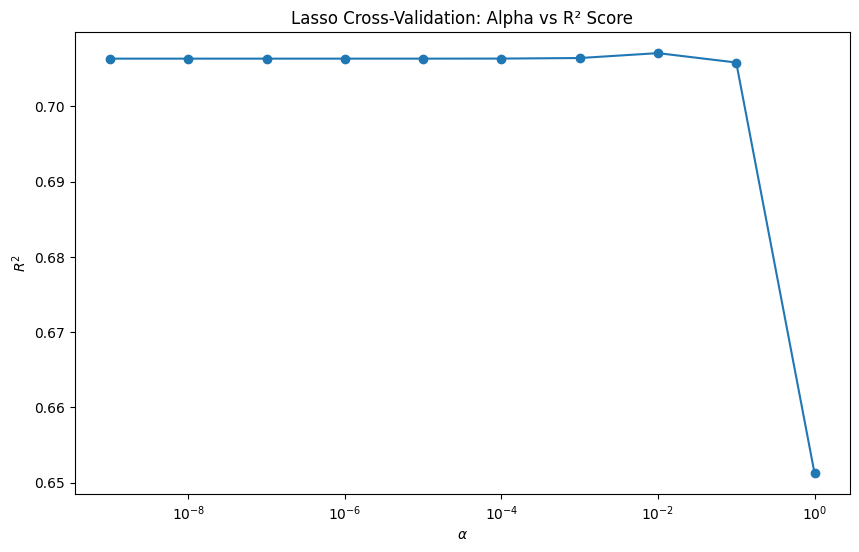

In [23]:
# Plot the relationship between alpha values and R² scores
# Semi-log plot helps visualize performance across different magnitudes of alpha
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')  # Regularization strength
plt.ylabel('$R^2$')     # Model performance
plt.title('Lasso Cross-Validation: Alpha vs R² Score');

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [24]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

If you store the results in a list called `scores`, the following will work:

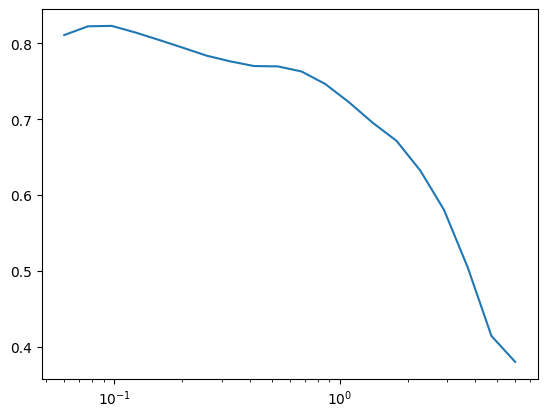

In [25]:
plt.semilogx(alphas, scores);

In [26]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [27]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -1.00309168e+00,  3.32679107e+00, -1.01840878e+00,
       -2.56161421e+00,  1.12778302e+00, -1.72266155e+00, -5.37088506e-01,
        4.39555878e-01, -3.39542586e+00,  7.22387712e-02,  0.00000000e+00,
        0.00000000e+00,  3.53653554e+00, -0.00000000e+00,  3.72285440e-01,
        0.00000000e+00,  0.00000000e+00, -5.49528703e-01, -0.00000000e+00,
       -0.00000000e+00, -4.05522485e-02,  2.25864611e-01,  1.78508858e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.50874606e-02,
       -0.00000000e+00, -2.07295802e-01, -0.00000000e+00,  3.71781995e-01,
        0.00000000e+00, -0.00000000e+00, -5.89531100e-02,  3.47180625e-01,
        0.00000000e+00,  9.23666274e-01,  3.48873365e-01,  7.29463442e-02,
        0.00000000e+00,  0.00000000e+00,  7.68485586e-02, -7.21083596e-01,
        0.00000000e+00, -5.98542558e-01,  4.18420677e-01, -7.98165728e-01,
       -7.25062683e-01,  

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

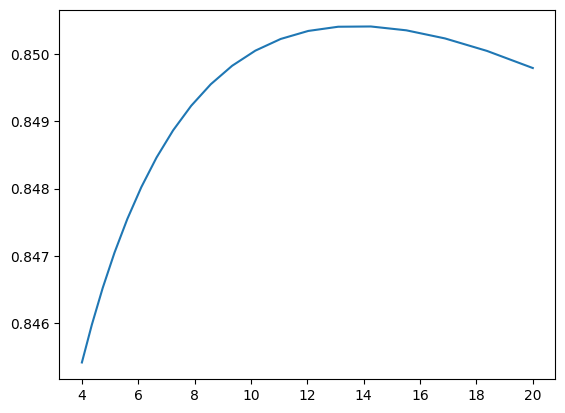

In [28]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

### Exercise:

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names_out()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.

In [29]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [30]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names_out(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [31]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [32]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [33]:
df_importances.sort_values(by=1)

,0,1
13,x12,-3.395426
8,x7,-2.561614
10,x9,-1.722662
94,x8 x12,-1.124408
72,x5 x8,-1.085987
...,...,...
9,x8,1.127783
79,x6 x8,1.363407
96,x9 x10,1.962870
6,x5,3.326791


## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [34]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [35]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [36]:
grid.best_score_, grid.best_params_

(0.8504982950750944,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 15.153673507519274})

In [37]:
y_predict = grid.predict(X)

In [38]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.9149145594213685

In [39]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00, -1.27346408e-01, -6.16205046e-03,  2.36135244e-02,
        1.00398027e-01, -9.74110586e-01,  3.26236441e+00, -9.65057238e-01,
       -1.96344725e+00,  8.56769182e-01, -1.01488960e+00, -7.06985966e-01,
        5.52029222e-01, -3.03254502e+00,  7.74127927e-02,  7.24276605e-02,
        6.82776638e-02,  1.72849044e+00, -4.80758341e-01,  5.76219972e-01,
        1.28132069e-01,  2.22931335e-01, -7.45243542e-01,  1.66582495e-01,
       -8.00025634e-02, -8.54571642e-02,  5.07490801e-01,  2.14820391e-01,
       -1.48833274e-01,  1.42098626e-01,  1.93770221e-01,  5.02304885e-02,
       -1.12667821e-01, -2.77559685e-01, -1.32870713e-01,  7.32239658e-01,
        5.26857333e-02,  8.89966580e-02, -2.72228558e-01,  5.84383917e-01,
        1.06306947e-01,  9.62971619e-01,  5.76845132e-01,  5.33378179e-01,
        7.07913980e-01, -6.21760626e-02,  7.57641545e-02, -4.28157866e-01,
        2.40651011e-01, -6.82201736e-01,  3.40931549e-01, -9.62217889e-01,
       -8.14997204e-01,  

In [40]:
grid.cv_results_

{'mean_fit_time': array([0.00518266, 0.00388551, 0.00392381, 0.00395552, 0.00362134,
        0.00350523, 0.00354735, 0.00488345, 0.00382566, 0.00299009,
        0.00355506, 0.00345969, 0.00359654, 0.00384649, 0.00372489,
        0.00478419, 0.00497397, 0.00599591, 0.01206239, 0.01135055,
        0.00742157, 0.00607371, 0.00378346, 0.00404453, 0.00357644,
        0.00304874, 0.0031321 , 0.00318249, 0.00381398, 0.00350229,
        0.00962098, 0.01275007, 0.01485523, 0.00670783, 0.00897821,
        0.00648705, 0.0085907 , 0.00812316, 0.00745034, 0.00865682,
        0.00885971, 0.00805306, 0.00970586, 0.00896915, 0.00878223,
        0.00663805, 0.00868289, 0.00798742, 0.01022665, 0.01146611,
        0.00945822, 0.00727423, 0.00455332, 0.00545605, 0.00862519,
        0.00748269, 0.0081358 , 0.00920852, 0.00815805, 0.00988245,
        0.02322928, 0.0207301 , 0.0219992 , 0.01875583, 0.02115703,
        0.01876275, 0.01279036, 0.01245538, 0.016481  , 0.01695522,
        0.01852202, 0.02799646,

## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.

---
### Machine Learning Foundation (C) 2020 IBM Corporation